In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# Recipe Analysis from Allrecipes.com

Using the Web Scraper notebook, we scraped recipes from www.allrecipes.com and loaded them into a JSON file called 'recipes.json'.  We will import this json file as a pandas DataFrame object and perform our analyses on that.

# Data Analysis

Now we have a JSON object which contains recipe information scraped from the web.  We can use this data and perform some analyses on it.

In [4]:
#load json object into dataframe
recipes = pd.read_json(r'recipes.json')

# re-order columns
recipes = recipes[['title', 'servings', 'cook_time', 'prep_time', 'additional_time', 
                   'total_time', 'ingredients', 'method', 'layout', 'picture']]
recipes.head()

,title,servings,cook_time,prep_time,additional_time,total_time,ingredients,method,layout,picture
0,Greek Chicken Skewers,4,20 mins,20 mins,2 hrs,2 hrs 40 mins,"[¼ cup lemon juice, ¼ cup wok oil, ⅛ cup red w...","[Whisk lemon juice, oil, vinegar, onion flakes...",2,https://imagesvc.meredithcorp.io/v3/mm/image?u...
1,World's Best Lasagna,12,2 hrs 30 mins,30 mins,15 mins,3 hrs 15 mins,"[1 pound sweet Italian sausage, ¾ pound lean g...","[In a Dutch oven, cook sausage, ground beef, o...",2,https://imagesvc.meredithcorp.io/v3/mm/image?u...
2,Best Chocolate Chip Cookies,24,10 mins,20 mins,30 mins,1 hr,"[1 cup butter, softened, 1 cup white sugar, 1 ...",[Preheat oven to 350 degrees F (175 degrees C)...,2,https://imagesvc.meredithcorp.io/v3/mm/image?u...
3,Fluffy Pancakes,4,10,10,,25,"[3/4 cup milk, 2 tablespoons white vinegar, 1 ...",[Combine milk with vinegar in a medium bowl an...,1,https://images.media-allrecipes.com/userphotos...
4,Good Old Fashioned Pancakes,8,15,5,,20,"[1 1/2 cups all-purpose flour, 3 1/2 teaspoons...","[In a large bowl, sift together the flour, bak...",1,https://images.media-allrecipes.com/userphotos...


### Analyzing Ingredients

Let's look at the ingredients that compose each recipe a bit more closely.  First, we want to know what the most common ingredients are among our scraped recipes.

In [5]:
all_ingredients_list = []

for row in recipes['ingredients']:
    for ing in row:
        all_ingredients_list.append(ing)

In [6]:
ingredients = pd.DataFrame(all_ingredients_list, columns=['ingredients'])
ingredients['edited'] = ingredients['ingredients']
ingredients.head()

,ingredients,edited
0,¼ cup lemon juice,¼ cup lemon juice
1,¼ cup wok oil,¼ cup wok oil
2,⅛ cup red wine vinegar,⅛ cup red wine vinegar
3,1 tablespoon onion flakes,1 tablespoon onion flakes
4,1 tablespoon minced garlic,1 tablespoon minced garlic


Now we attempt to clean the ingredients list to get rid of the 'noise' and have a raw list of ingredient names without units, numbers or descriptors.

In [7]:
# lists of common measuring and descriptive words we want to remove
units = ['gallon','quart','pint','cup','teaspoon','tablespoon','ounce','pound','can','pinch','serving','slice','package','bottle']
descriptors = ['small','medium','large']

# remove common measuring and descriptive words
for word in units + descriptors:
    plural = word+"s"
    ingredients['edited'] = ingredients['edited'].str.replace(' '+plural+' ', ' ')
    ingredients['edited'] = ingredients['edited'].str.replace(' '+word+' ','')

#remove common leading descriptors
ingredients['edited'] = ingredients['edited'].str.replace('boneless,','')
ingredients['edited'] = ingredients['edited'].str.replace('skinless,','')
ingredients['edited'] = ingredients['edited'].str.replace('boneless','')
ingredients['edited'] = ingredients['edited'].str.replace('skinless','')
    
# remove parantheicals
ingredients['edited'] = ingredients['edited'].str.replace(r'\([^()]*\)','')
# remove text after commas and hyphens
ingredients['edited'] = ingredients['edited'].str.partition(',')
ingredients['edited'] = ingredients['edited'].str.partition(',')
# remove non-alphabetical characters
ingredients['edited'] = ingredients['edited'].str.replace('[^a-zA-Z]', ' ')

# edit down extra spaces caused by adjacent removals
ingredients['edited'] = ingredients['edited'].str.strip()

#fix other miscellaneous common errors
ingredients['edited'] = ingredients['edited'].str.replace('eggs','egg')

ingredients.head()

,ingredients,edited
0,¼ cup lemon juice,lemon juice
1,¼ cup wok oil,wok oil
2,⅛ cup red wine vinegar,red wine vinegar
3,1 tablespoon onion flakes,onion flakes
4,1 tablespoon minced garlic,minced garlic


From here we can investigate which ingredients are the most common.  First, we see which edited rows appear most commonly with a call to .value_counts()

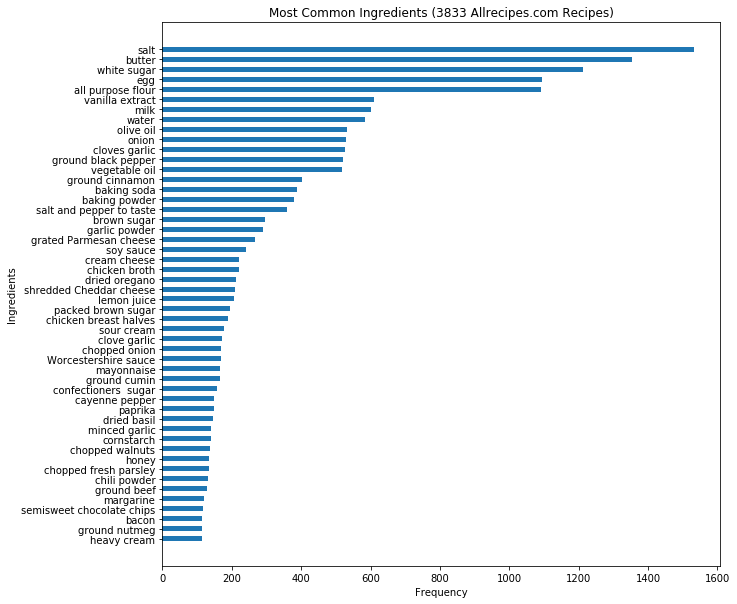

In [8]:
fig, ax = plt.subplots(figsize = (10,10))

n = 50
bar_positions = np.arange(n)
bar_heights = ingredients['edited'].value_counts().head(n)
bar_names = ingredients['edited'].value_counts().head(n).index

ax.barh(bar_positions, bar_heights, 0.5)
ax.set_yticks(bar_positions)
ax.set_yticklabels(bar_names)
ax.set_title('Most Common Ingredients (' + str(recipes.shape[0]) + ' Allrecipes.com Recipes)')
ax.set_ylabel('Ingredients')
ax.set_xlabel('Frequency')
ax.invert_yaxis()
plt.show()

### Analyzing Servings

Each recipe has a listed servings amount.  These are stored as integer values already, so should be simple to visualize.

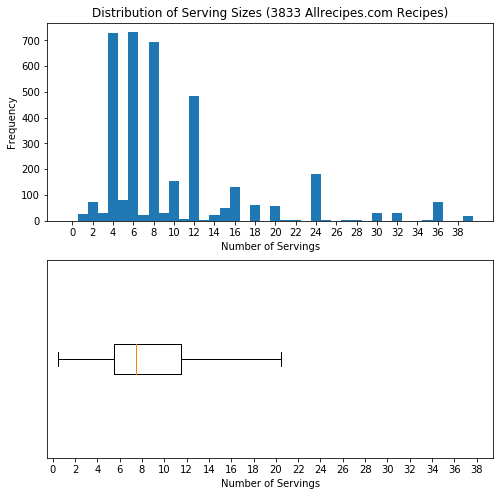

In [9]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

max = 40
tick_values = 2 * np.arange(int(max/2))
tick_positions = tick_values + 0.5

ax1.hist(recipes['servings'], bins=max, range=(0,max))
ax1.set_title('Distribution of Serving Sizes (' + str(recipes.shape[0]) + ' Allrecipes.com Recipes)')
ax1.set_xticklabels(tick_values)
ax1.set_xticks(tick_positions)
ax1.set_xlabel('Number of Servings')
ax1.set_ylabel('Frequency')

ax2.boxplot(recipes['servings'], vert=False, sym='')
ax2.set_xlim(0,max)
ax2.set_xticklabels(tick_values)
ax2.set_xticks(tick_positions)
ax2.set_yticks([])
ax2.set_xlabel('Number of Servings')

plt.show()

So, we notice that the number of servings has a skewed right distribution, with the mode at 6 servings.  We also see that common breakpoint values seem to favored, such as 4, 6, 8, 12, 16, 24, and 36.  The most common values are 6, 8, 4, and 12.

### Analyzing Cooking, Prep, and Total Time

All of the scraped recipes have columns for Prep Time, Cook Time, Additional Time, and Total Time.  Some of these values are blank, and all are stored as string objects.  Some strings have units attached and others do not, so we will need to do some cleaning to get them all to numerical values.

In [10]:
time_columns = ['cook_time','prep_time','additional_time','total_time']
recipes[time_columns].head(10)

,cook_time,prep_time,additional_time,total_time
0,20 mins,20 mins,2 hrs,2 hrs 40 mins
1,2 hrs 30 mins,30 mins,15 mins,3 hrs 15 mins
2,10 mins,20 mins,30 mins,1 hr
3,10,10,,25
4,15,5,,20
5,1 hr 5 mins,15 mins,,1 hr 20 mins
6,1 hr,30 mins,,1 hr 30 mins
7,25,20,,45
8,20 mins,15 mins,,35 mins
9,25 mins,15 mins,,40 mins


In [11]:
# convert string values to floats
for column in time_columns:
    new_column = []
    for row in recipes[column]:
        hrs_mins = []  # list containing [hours, minutes]

        if 'day' in row:
            num_days = re.split('days|day', row)[0]
            row = str(int(num_days)*24) + ' hrs'
            
        if 'hr' in row:
            hrs_mins = re.split('hrs|hr',row)
            hrs_mins[1] = hrs_mins[1].replace('mins','')
            hrs_mins[1] = hrs_mins[1].replace('min','')
        else:
            row = row.replace('mins','')
            row = row.replace('min','')
            hrs_mins = [0,row]
        
        if hrs_mins[1] == '':
            hrs_mins[1] = 0
            
        num_value = float(hrs_mins[0]) + (float(hrs_mins[1]) / 60)
        new_column.append(num_value)
        
    recipes[column] = new_column
    
recipes[time_columns].head(10)

,cook_time,prep_time,additional_time,total_time
0,0.333333,0.333333,2.00,2.666667
1,2.500000,0.500000,0.25,3.250000
2,0.166667,0.333333,0.50,1.000000
3,0.166667,0.166667,0.00,0.416667
4,0.250000,0.083333,0.00,0.333333
5,1.083333,0.250000,0.00,1.333333
6,1.000000,0.500000,0.00,1.500000
7,0.416667,0.333333,0.00,0.750000
8,0.333333,0.250000,0.00,0.583333
9,0.416667,0.250000,0.00,0.666667


Although we converted the 'additional_time' column to a float as well, we will not look at it in our analysis below.  The reason for this is there are many inconsistencies where the columns do not add up to the total. Rather than evaluate which column is the issue in each case, we will simply toss out the additional time column, as it is not important to our analysis.

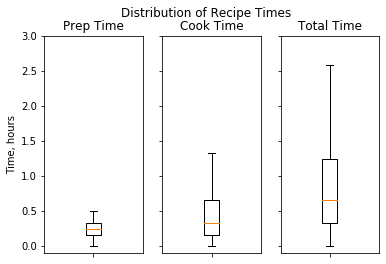

In [12]:
fig = plt.figure()
fig.suptitle('Distribution of Recipe Times')
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

min = -.1
max = 3

ax1.boxplot(recipes['prep_time'],sym='')
ax1.set_ylim((min, max))
ax1.set_xticklabels([])
ax1.set_ylabel('Time, hours')
ax1.set_title("Prep Time")

ax2.boxplot(recipes['cook_time'],sym='')
ax2.set_ylim((min, max))
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_title("Cook Time")

ax3.boxplot(recipes['total_time'],sym='')
ax3.set_ylim((min, max))
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_title("Total Time")

plt.show()

Here, we can see boxplots of the time it takes for each of prepping, cooking, and the total time for each recipe.

### Analyzing Titles

We can look through the titles of each recipe to find common trends among all of them.

In [13]:
title_words_list = []
for row in recipes['title']:
    for word in row.split(' '):
        word = re.sub('[^a-zA-Z]', '', word)
        
        title_words_list.append(word)
        
title_words = pd.DataFrame(title_words_list, columns = ['words'])

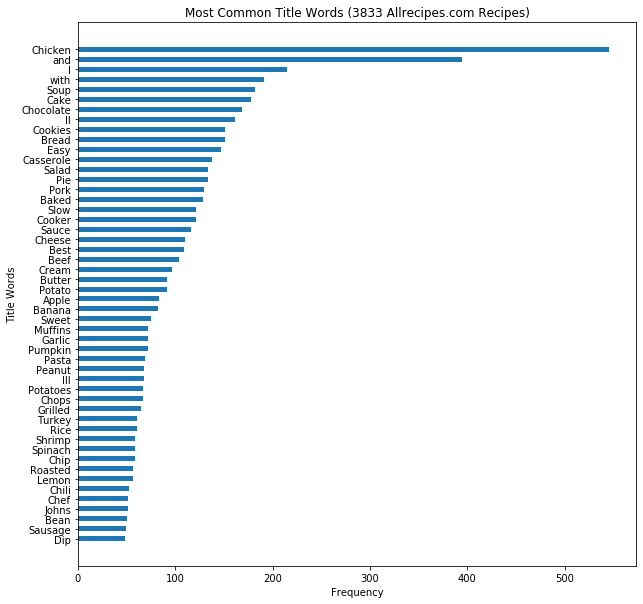

In [14]:
fig, ax = plt.subplots(figsize = (10,10))

n = 50
bar_positions = np.arange(n)
bar_heights = title_words['words'].value_counts().head(n)
bar_names = title_words['words'].value_counts().head(n).index

ax.barh(bar_positions, bar_heights, 0.5)
ax.set_yticks(bar_positions)
ax.set_yticklabels(bar_names)
ax.set_title('Most Common Title Words (' + str(recipes.shape[0]) + ' Allrecipes.com Recipes)')
ax.set_ylabel('Title Words')
ax.set_xlabel('Frequency')
ax.invert_yaxis()
plt.show()

### Instruction  Analysis

Next we want to analyze the most common 'cooking verbs' used in recipe instructions.  However, we don't have a good way to extract specifically cooking verbs from the instruction strings.  So, we will first extract the most common verbs manually with a fixed dataset, and then count the instances of those in future sets.  This process is certainly imperfect, but since we don't have a filter to determine cooking verbs from other types of words, this will be our approach.

In [15]:
words_list = []
for method in recipes['method']:
    for instruction in method:
        words = instruction.split(' ')
        for word in words:
            word = re.sub('[^a-zA-Z]', '', word).lower()
            words_list.append(word)

In [16]:
method_words = pd.DataFrame(words_list, columns =['words'])

By manually searching through the top 100 words collected, we compiled the list below, saved as 'words_to_include'.  We then re-build the words list using only these words.

In [17]:
words_to_include = ['stir','cook','mix','place','add','bake','preheat','pour','cover','combine','remove','boil','cool','bring','simmer','set','sprinkle','beat','serve','drain','let']
words_list_limited = []
for method in recipes['method']:
    for instruction in method:
        words = instruction.split(' ')
        for word in words:
            word = re.sub('[^a-zA-Z]', '', word).lower().strip()
            
            if word in words_to_include:
                words_list_limited.append(word)
            
method_words_limited = pd.DataFrame(words_list_limited, columns =['words'])

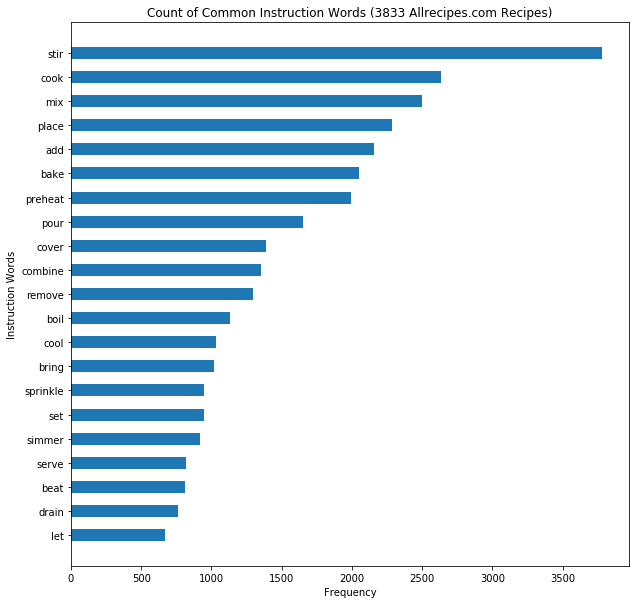

In [18]:
fig, ax = plt.subplots(figsize = (10,10))

n = len(method_words_limited['words'].value_counts())
bar_positions = np.arange(n)
bar_heights = method_words_limited['words'].value_counts().head(n)
bar_names = method_words_limited['words'].value_counts().head(n).index

ax.barh(bar_positions, bar_heights, 0.5)
ax.set_yticks(bar_positions)
ax.set_yticklabels(bar_names)
ax.set_title('Count of Common Instruction Words (' + str(recipes.shape[0]) + ' Allrecipes.com Recipes)')
ax.set_ylabel('Instruction Words')
ax.set_xlabel('Frequency')
ax.invert_yaxis()
plt.show()